In [1]:
import sys; sys.path.append('../code')

import matplotlib.pyplot as plt
plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']

plt.rcParams['text.usetex'] = False
#plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["ps.usedistiller"] = 'xpdf'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["mathtext.fontset"] = 'cm'

from plot_utility import mathify_ticklabels

/home/caveman/TEST38/lib/python3.8/site-packages/pynumdiff-0.1.dev0-py3.8.egg/pynumdiff/total_variation_regularization/__total_variation_regularization__.py:12: UserWarning: Could not import cvxpy. Install cvxpy (http://www.cvxpy.org/install/index.html) to use                    convex total variation regularized derivatives.                    Recommended solver: MOSEK, free academic license available: https://www.mosek.com/products/academic-licenses/                    You can still use the iterative method.
/home/caveman/TEST38/lib/python3.8/site-packages/pynumdiff-0.1.dev0-py3.8.egg/pynumdiff/linear_model/__linear_model__.py:22: UserWarning: Could not import pychebfun. Install pychebfun (https://github.com/pychebfun/pychebfun/) to use chebfun derivatives.
/home/caveman/TEST38/lib/python3.8/site-packages/pynumdiff-0.1.dev0-py3.8.egg/pynumdiff/linear_model/__linear_model__.py:26: UserWarning: Could not import pydmd. Install pydmd (florisvb fork: https://github.com/florisvb/PyDMD) to 

In [2]:
import pandas as pd
import utility
import plot_utility
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import figurefirst as fifi
import pickle

In [3]:
from plot_utility import load_real_wind, get_filenames_sorted_by_tau_and_T, plot_error_heatmap
from plot_utility import get_optimal_psifreq_tau_vs_noise, plot_example_zeta_timeseries
from plot_utility import get_error_heatmap_for_Tmultiplier
import direct_trajectory_simulator

try:
    import run_analysis
except:
    import run_analysis_180 as run_analysis

probably could not import cvxpy, not an issue if you dont need it here


In [4]:
FONTSIZE = 7

In [16]:
def plot_trajectory(option, ax, colormap='bone_r', turn_amplitude = '180deg'):
    if option == 'constantvel':
        velocity_profile='constant'
    else:
        velocity_profile='absine'
    
    if option == 'constantgamma':
        phi='align_gamma'
    else:
        phi='align_psi'
        
    psi_freq = 0.1
    smoothness_weight = 1
    df, bmp = run_analysis.get_df_random( wind='realdynamic', 
                       L=300, 
                       psi_freq=psi_freq,
                       dt=0.1,
                       t=None,
                       turn_amplitude=turn_amplitude,
                       smoothness_weight=smoothness_weight,
                       angular_noise_std=0,
                       of_noise_std=0,
                       air_noise_std=0,
                       velocity_profile=velocity_profile,
                       phi=phi,
                       random_seed=7)

    direct_trajectory_simulator.plot_trajec(df, ax=ax, size_radius=0.4, nskip = 3, 
                                            show_wind_quivers=False, colormap=colormap)

    xmean = df.xpos.mean()
    ymean = df.ypos.mean()

    x = 4
    y = 4
    ax.set_xlim(xmean-x, xmean+x)
    ax.set_ylim(ymean-y, ymean+y)

In [17]:
def get_optimal_error_tau_psifreq_for_trange(trange, wind_df, candidates, wind_type):

    q = 'time_epoch > ' + str(trange[0]) + ' and time_epoch < ' + str(trange[-1])
    wind_df_q = wind_df.query(q)

    middle_ix = int(len(wind_df_q.zeta.values)/2.)
    dcmedian = np.median( np.abs(utility.wrap_angle( wind_df_q.zeta.values[middle_ix] - wind_df_q.zeta.values )) )
    mcmedian = np.median( np.abs(wind_df_q.w.values[middle_ix] - wind_df_q.w.values)) / np.mean(wind_df_q.w)
    
    dcmean = np.mean( np.abs(utility.wrap_angle( wind_df_q.zeta.values[middle_ix] - wind_df_q.zeta.values )) )
    mcmean = np.mean( np.abs(wind_df_q.w.values[middle_ix] - wind_df_q.w.values)) / np.mean(wind_df_q.w)
    
    dcstd = np.std( np.abs(utility.wrap_angle( wind_df_q.zeta.values[middle_ix] - wind_df_q.zeta.values )) )
    mcstd = np.std( np.abs(wind_df_q.w.values[middle_ix] - wind_df_q.w.values)) / np.mean(wind_df_q.w)
    
    dc = np.max( np.abs(utility.wrap_angle( wind_df_q.zeta.values[middle_ix] - wind_df_q.zeta.values )) )
    mc = np.max( np.abs(wind_df_q.w.values[middle_ix] - wind_df_q.w.values)) / np.mean(wind_df_q.w)

    errors = []
    taus = []
    psi_freqs = []

    for filename in candidates:
        data = pd.read_hdf(filename)
        data_q = data.query('t > ' + str(trange[0]) + ' and t < ' + str(trange[-1]) )

        if len(data_q) > 0:
            errors.append( np.median( np.abs(utility.wrap_angle(data_q.zeta_est - data_q.zeta_true)) ) )
            taus.append(data_q.tau.values[0])
            psi_freqs.append(data_q.psi_freq.values[0])

    minerror = np.min(errors)
    ixs = np.where( np.array(errors) < minerror*1.05)[0]
    
    if wind_type == 'dynamic':
        wind_type = 1
    else:
        wind_type = 0
    
    return np.array(errors)[ixs].tolist(), np.array(taus)[ixs].tolist(), np.array(psi_freqs)[ixs].tolist(), len(ixs)*[dc], len(ixs)*[mc], len(ixs)*[dcmedian], len(ixs)*[mcmedian], len(ixs)*[dcmean], len(ixs)*[mcmean], len(ixs)*[dcstd], len(ixs)*[mcstd], len(ixs)*[trange[-1]-trange[0]], len(ixs)*[wind_type]

In [31]:
def get_opt_dataframe(turn_amplitude, angular_noise_std, phi_alignment, velocity, N=20):
    
    wind_type = 'dynamic'
    wind_df, zeta, w, t, dt = plot_utility.load_real_wind(wind_type)
    wind_df.time_epoch = wind_df.time_epoch - wind_df.time_epoch.values[0]

    tranges = []
    for i in range(N):
        t0 = np.random.randint(0, wind_df.time_epoch.max())
        tstep = np.random.randint(1, 1000)
        tranges.append([t0, t0+tstep])

    directory = '/home/caveman/Sync/LAB_Private/PAPERS/2021_simulation_botfly_PAPER/data_simulations/20220301_seed1_' + velocity + '_' + phi_alignment + '_real' + wind_type
    basename = 'cvx_windreal' + wind_type + '_random_turnamplitude' + str(turn_amplitude) + 'deg_' + velocity

    candidates = get_filenames_sorted_by_tau_and_T(directory, basename, 
                                                       angular_noise_std=angular_noise_std, 
                                                       Tmultiplier=1,
                                                       phi_alignment=phi_alignment,
                                                       paramX=None)[0]

    rdynamic = [get_optimal_error_tau_psifreq_for_trange(trange, wind_df, candidates, wind_type) for trange in tranges]

    ##########
    if phi_alignment == 'alignpsi' and velocity == 'absine':
        wind_type = 'constant'
        wind_df, zeta, w, t, dt = plot_utility.load_real_wind(wind_type)
        wind_df.time_epoch = wind_df.time_epoch - wind_df.time_epoch.values[0]

        tranges = []
        for i in range(N):
            t0 = np.random.randint(0, wind_df.time_epoch.max())
            tstep = np.random.randint(1, 1000)
            tranges.append([t0, t0+tstep])

        directory = '/home/caveman/Sync/LAB_Private/PAPERS/2021_simulation_botfly_PAPER/data_simulations/20220301_seed1_' + velocity + '_' + phi_alignment + '_real' + wind_type
        basename = 'cvx_windreal' + wind_type + '_random_turnamplitude' + str(turn_amplitude) + 'deg_' + velocity

        candidates = get_filenames_sorted_by_tau_and_T(directory, basename, 
                                                           angular_noise_std=angular_noise_std, 
                                                           Tmultiplier=1,
                                                           phi_alignment=phi_alignment,
                                                           paramX=None)[0]

        rconstant = [get_optimal_error_tau_psifreq_for_trange(trange, wind_df, candidates, wind_type) for trange in tranges]
    else:
        rconstant = None
        
    rdynamic = np.hstack(rdynamic).T
    
    if rconstant is not None:
        rconstant = np.hstack(rconstant).T
        r = np.vstack((rdynamic, rconstant))
    else:
        r = rdynamic
    
    df = pd.DataFrame(data=r, index=None, columns=['error', 'tau', 'psi_freq', 'dcmax', 'mcmax', 'dcmedian', 'mcmedian', 'dcmean', 'mcmean', 'dcstd', 'mcstd','tlength', 'wind_type']) 
    
    return df

In [19]:
use_pickled_data = True
fname = '../data_simulations_summary/data_for_summary_plot.pickle'

if not use_pickled_data:
    N = 1000
    turn_angles = [20, 90, 180]
    noise_stds = [0.3, 0.6, 1.2]
    options = [ ['alignpsi', 'absine'], ['alignpsi', 'constant'], ['aligngamma', 'absine'] ]

    data_for_summary_plot = {}
    for turn_angle in turn_angles:
        for noise_std in noise_stds:
            for option in options:
                phi_alignment, speed = option
                label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
                df = get_opt_dataframe(turn_angle, noise_std, phi_alignment, speed, N=N)
                data_for_summary_plot[label] = df
                
    pickle.dump(data_for_summary_plot, open( fname, "wb" ) )
else:
    data_for_summary_plot = pickle.load( open( fname, "rb" ) )

15000 0.09999990463256836
only finding filenames containing: alignpsi
7000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.09999990463256836
only finding filenames containing: aligngamma
15000 0.09999990463256836
only finding filenames containing: alignpsi
7000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.09999990463256836
only finding filenames containing: aligngamma
15000 0.09999990463256836
only finding filenames containing: alignpsi
7000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.09999990463256836
only finding filenames containing: aligngamma
15000 0.09999990463256836
only finding filenames containing: alignpsi
7000 0.09999990463256836
only finding filenames containing: alignpsi
15000 0.0999999046

In [68]:
def plot_noise_level(fififig, noise_level, df, show_labels=False, show_scatters=True, 
                     figpanel_save=None, color='green', mean_offset=0):
    #df = dfs[noise_level]
    figpanel = 'noise'+str(noise_level)
    if figpanel_save is None:
        figpanel_save = figpanel

    borders = [[0, 0.5],
               [0.5, 1],
               [1, 1.5],
               [1.5, 2],
               [2, 3.2]]

    alpha = 0.3
    
    if mean_offset > 0:
        offset_x = 0.15
    elif mean_offset < 0:
        offset_x = -0.15
    else:
        offset_x = 0
    
    error_ticks = np.array([0, 10, 20, 30])*np.pi/180.
    error_ticks_deg = [0, 10, 20, 30]
    
    
    angle_ticks = [0, np.pi/4., np.pi/2., 3*np.pi/4., np.pi]
    angle_ticks_deg = [0, 45, 90, 135, 180]

    speed_ticks = [0, 1, 2, 3]
    tau_ticks = [0.4, 2, 10, 50, 250]
    psi_ticks = [0.01, 0.02, 0.1, 0.5, 1.25]

    layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

    #####################################################
    ax = layout.axes[(figpanel, 'windspeed')]
    x_key = 'mcmax'
    y_key = 'error'
    
    if show_scatters:
        ax.plot(df[df.wind_type==1][x_key], df[df.wind_type==1].error, '.', color=color, markersize=0.25, rasterized=True, alpha=alpha)
        ax.plot(df[df.wind_type==0][x_key], df[df.wind_type==0].error, 'o', color=color, markersize=0.25, rasterized=True, alpha=alpha)
    fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                         yticks = error_ticks,
                                         xticks = speed_ticks,
                                         spine_locations={'left': 5, 'bottom': 5},
                                         default_ticks=False,
                                         tick_length=2.5,
                                         linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([r'$'+str(tick)+r'^{\circ}$' for tick in error_ticks_deg])
    if show_labels:
        mathify_ticklabels(ax, 'x', speed_ticks)
        ax.set_xlabel('Max change\nin wind speed, m/s')
        ax.set_ylabel('Median error for $\hat{\zeta}$')
    ax.set_ylim(error_ticks[0], error_ticks[-1])
    ax.set_xlim(speed_ticks[0], speed_ticks[-1])
    
    summary_x = []
    summary_y = []
    for border in borders:
        q = x_key + ' > ' + str(border[0]) + ' and ' + x_key + ' <= ' + str(border[-1])
        dfq = df.query(q)
        if len(dfq) > 10:
            mean_y_key = dfq[y_key].mean() 

            sorted = np.sort(dfq[y_key].values)
            N = len(sorted)
            ixmed = int(0.5*N)
            ixlo = int(0.05*N)
            ixhi = int(0.95*N)

            ax.plot( dfq[x_key].mean()+offset_x, mean_y_key, 's', markersize=3, color=color)
            summary_x.append(dfq[x_key].mean()+offset_x)
            summary_y.append(mean_y_key)
            #ax.vlines( dfq[x_key].mean()+offset_x, sorted[ixlo], sorted[ixhi], color=color, linewidths=0.5 )
    ax.plot( summary_x, summary_y, color=color, linewidth=1)
    
    ##########################################################
    ax = layout.axes[('noise'+str(noise_level), 'winddirection')]
    x_key = 'dcmax'
    y_key = 'error'
    
    if show_scatters:
        ax.plot(df[df.wind_type==1][x_key], df[df.wind_type==1].error, '.', color=color, markersize=0.25, rasterized=True, alpha=alpha)
        ax.plot(df[df.wind_type==0][x_key], df[df.wind_type==0].error, 'o', color=color, markersize=0.25, rasterized=True, alpha=alpha)
    fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                         yticks = error_ticks,
                                         xticks = angle_ticks,
                                         spine_locations={'left': 5, 'bottom': 5},
                                         default_ticks=False,
                                         tick_length=2.5,
                                         linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([r'$'+str(tick)+r'^{\circ}$' for tick in error_ticks_deg])
    if show_labels:
        ax.set_xticklabels([r'$'+str(tick)+r'^{\circ}$' for tick in angle_ticks_deg])
        ax.set_xlabel('Max change\nin wind direction')
        ax.set_ylabel('Median error for $\hat{\zeta}$')
    ax.set_ylim(error_ticks[0], error_ticks[-1])
    ax.set_xlim(angle_ticks[0], angle_ticks[-1]*1.2)
    
    summary_x = []
    summary_y = []
    for border in borders:
        q = x_key + ' > ' + str(border[0]) + ' and ' + x_key + ' <= ' + str(border[-1])
        dfq = df.query(q)
        if len(dfq) > 10:
            mean_y_key = dfq[y_key].mean() 

            sorted = np.sort(dfq[y_key].values)
            N = len(sorted)
            ixmed = int(0.5*N)
            ixlo = int(0.05*N)
            ixhi = int(0.95*N)

            ax.plot( dfq[x_key].mean()+offset_x, mean_y_key, 's', markersize=3, color=color)
            summary_x.append(dfq[x_key].mean()+offset_x)
            summary_y.append(mean_y_key)
            #ax.vlines( dfq[x_key].mean()+offset_x, sorted[ixlo], sorted[ixhi], color=color, linewidths=0.5 )
    ax.plot( summary_x, summary_y, color=color, linewidth=1)
    ###########################################################
    ax = layout.axes[('noise'+str(noise_level), 'tau')]
    x_key = 'dcmedian'
    y_key = 'tau'

    jitter = (np.random.random(len(df)) - 0.5)/2.
    jitter += 1#*np.sign(jitter)
    
    yvals = df[y_key].values*jitter
    if show_scatters:
        ax.plot(df[x_key].values, yvals, '.', color=color, markersize=0.25, rasterized=True, alpha=alpha)

    summary_x = []
    summary_y = []
    for border in borders:
        q = x_key + ' > ' + str(border[0]) + ' and ' + x_key + ' <= ' + str(border[-1])
        dfq = df.query(q)
        if len(dfq) > 10:
            mean_y_key = dfq[y_key].mean() 

            sorted = np.sort(dfq[y_key].values)
            N = len(sorted)
            ixmed = int(0.5*N)
            ixlo = int(0.05*N)
            ixhi = int(0.95*N)

            ax.plot( dfq[x_key].mean()+offset_x, mean_y_key, 's', markersize=3, color=color)
            summary_x.append(dfq[x_key].mean()+offset_x)
            summary_y.append(mean_y_key)
            #ax.vlines( dfq[x_key].mean()+offset_x, sorted[ixlo], sorted[ixhi], color=color, linewidths=0.5 )
    ax.plot( summary_x, summary_y, color=color, linewidth=1)
    
    ax.set_yscale('log')

    fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                         yticks = tau_ticks,
                                         xticks = angle_ticks,
                                         spine_locations={'left': 5, 'bottom': 5},
                                         default_ticks=False,
                                         tick_length=2.5,
                                         linewidth=0.5)
    ax.minorticks_off()
    ax.set_xticklabels([])
    ax.set_yticklabels(tau_ticks)
    mathify_ticklabels(ax, 'y', tau_ticks)
    ax.set_ylim(tau_ticks[0]*0.95, tau_ticks[-1]*1.5)
    ax.set_xlim(angle_ticks[0], angle_ticks[-1])
    
    if show_labels:
        ax.set_xticklabels([r'$'+str(tick)+r'^{\circ}$' for tick in angle_ticks_deg])
        ax.set_xlabel('Median change\nin wind direction')
        ax.set_ylabel(r'Optimal $\tau$, sec')

    ###################################################################
    ax = layout.axes[('noise'+str(noise_level), 'psi_freq')]
    x_key = 'dcmedian'
    y_key = 'psi_freq'

    jitter = (np.random.random(len(df)) - 0.5)/2.
    jitter += 1 #*np.sign(jitter)
    yvals = df[y_key].values*jitter
    yvals = yvals - np.mean(yvals) + np.mean(df[y_key].values)
    if show_scatters:
        ax.plot(df[x_key].values, yvals, '.', color=color, markersize=0.25, rasterized=True, alpha=alpha)

    summary_x = []
    summary_y = []
    for border in borders:
        q = x_key + ' > ' + str(border[0]) + ' and ' + x_key + ' <= ' + str(border[-1])
        dfq = df.query(q)
        if len(dfq) > 10:
            mean_y_key = dfq[y_key].mean() 

            sorted = np.sort(dfq[y_key].values)
            N = len(sorted)
            ixmed = int(0.5*N)
            ixlo = int(0.05*N)
            ixhi = int(0.95*N)

            ax.plot( dfq[x_key].mean()+offset_x, mean_y_key, 's', markersize=3, color=color)
            summary_x.append(dfq[x_key].mean()+offset_x)
            summary_y.append(mean_y_key)
            #ax.vlines( dfq[x_key].mean()+offset_x, sorted[ixlo], sorted[ixhi], color=color, linewidths=0.5)
    ax.plot( summary_x, summary_y, color=color, linewidth=1)
    
    ax.set_yscale('log')

    fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                         yticks = psi_ticks,
                                         xticks = angle_ticks,
                                         spine_locations={'left': 5, 'bottom': 5},
                                         default_ticks=False,
                                         tick_length=2.5,
                                         linewidth=0.5)
    ax.minorticks_off()
    ax.set_xticklabels([])
    ax.set_yticklabels(psi_ticks)
    mathify_ticklabels(ax, 'y', psi_ticks)
    ax.set_ylim(psi_ticks[0]*0.95, psi_ticks[-1]*1.5)
    ax.set_xlim(angle_ticks[0], angle_ticks[-1])
    
    if show_labels:
        ax.set_xticklabels([r'$'+str(tick)+r'^{\circ}$' for tick in angle_ticks_deg])
        ax.set_xlabel('Median change\nin wind direction')
        ax.set_ylabel('Optimal turning\nfrequency, Hz')
    ##
    
    fifi.mpl_functions.set_fontsize(ax, FONTSIZE)

    layout.append_figure_to_layer(layout.figures[figpanel], figpanel_save, cleartarget=True)
    layout.write_svg(fififig)

# Noise analysis

In [69]:
fififig = '../figures_svg/fig_11_summary.svg'

/home/caveman/TEST38/lib/python3.8/site-packages/figurefirst/svg_to_axes.py:1041: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(fw_in, fh_in))


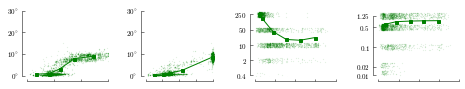

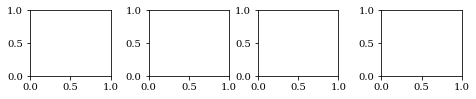

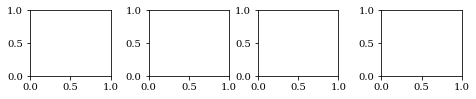

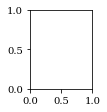

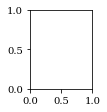

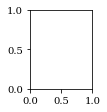

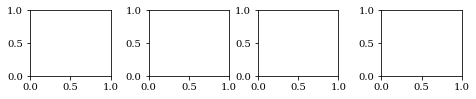

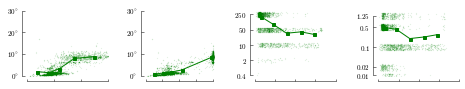

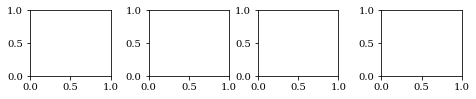

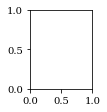

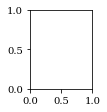

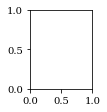

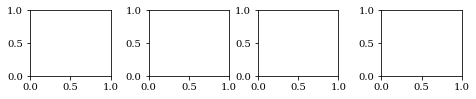

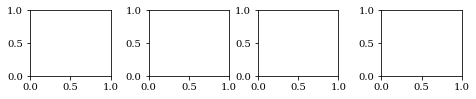

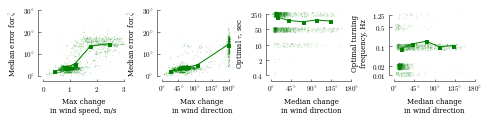

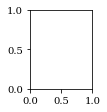

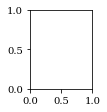

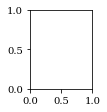

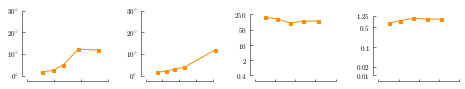

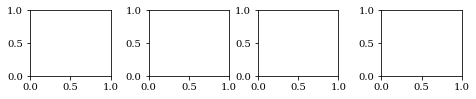

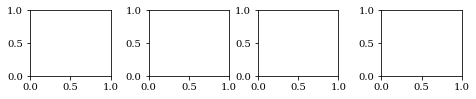

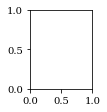

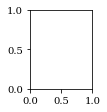

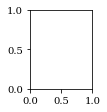

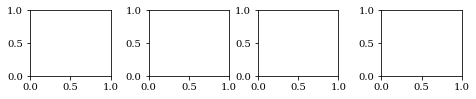

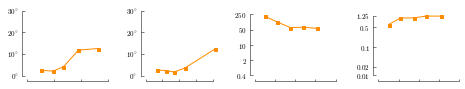

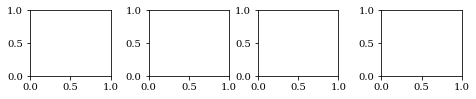

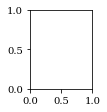

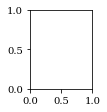

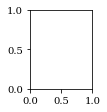

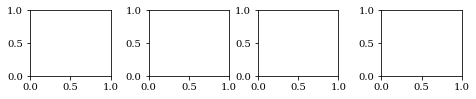

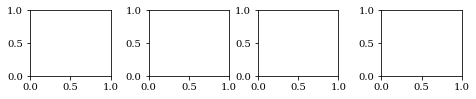

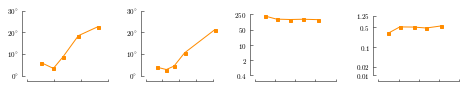

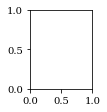

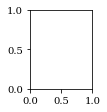

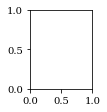

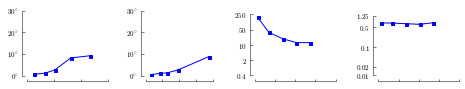

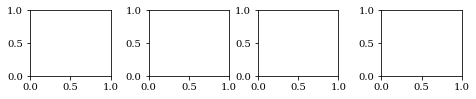

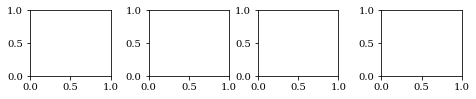

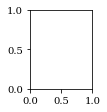

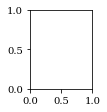

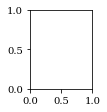

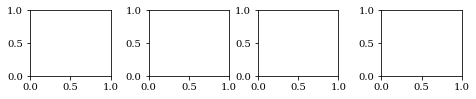

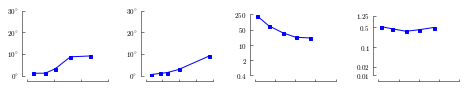

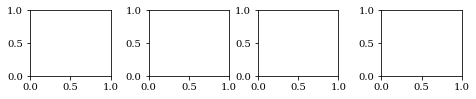

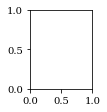

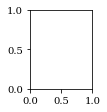

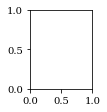

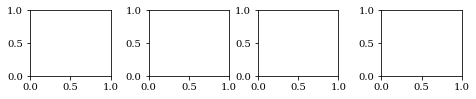

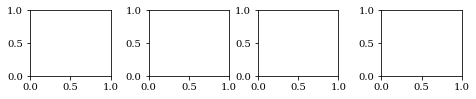

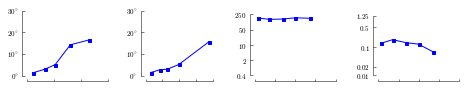

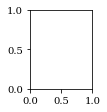

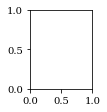

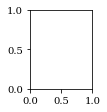

In [70]:
for noise_std in [0.3, 0.6, 1.2]:
    turn_angle = 180
    phi_alignment = 'alignpsi'
    speed = 'absine'
    label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
    df = data_for_summary_plot[label]
    
    if noise_std == 1.2:
        show_labels = True
    else:
        show_labels = False
    plot_noise_level(fififig, int(noise_std*10), df, color='green', show_labels=show_labels)
    
    
    
for noise_std in [0.3, 0.6, 1.2]:
    turn_angle = 20
    phi_alignment = 'alignpsi'
    speed = 'absine'
    label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
    df = data_for_summary_plot[label]
    
    show_labels = False
    plot_noise_level(fififig, int(noise_std*10), df, color='darkorange', show_scatters=False,
                     figpanel_save=str(noise_std)+'_20', mean_offset=1)
    
for noise_std in [0.3, 0.6, 1.2]:
    turn_angle = 90
    phi_alignment = 'alignpsi'
    speed = 'absine'
    label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
    df = data_for_summary_plot[label]
    
    show_labels = False
    plot_noise_level(fififig, int(noise_std*10), df, color='blue', show_scatters=False,
                     figpanel_save=str(noise_std)+'_90', mean_offset=-1)

300 0.09999990463256836
Number of turns per sec:  0.16722423974502104


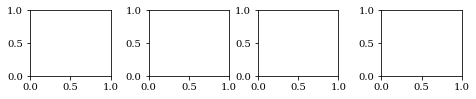

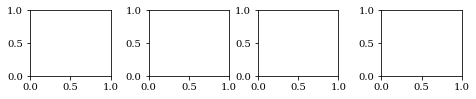

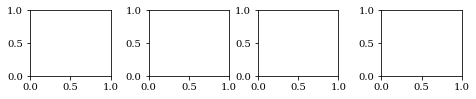

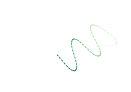

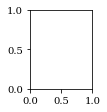

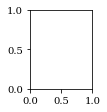

In [71]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('trajec', 'trajec')]
plot_trajectory('alignpsi', ax, colormap='Greens', turn_amplitude = '180deg')

layout.append_figure_to_layer(layout.figures['trajec'], 'trajec180', cleartarget=True)
layout.write_svg(fififig)

300 0.09999990463256836
Number of turns per sec:  0.16722423974502104


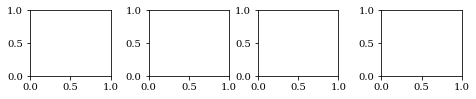

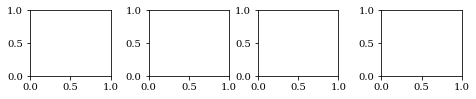

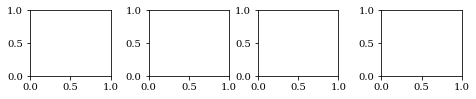

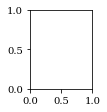

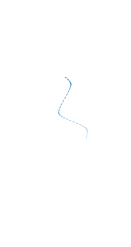

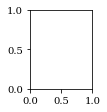

In [72]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('trajec2', 'trajec')]
plot_trajectory('alignpsi', ax, colormap='Blues', turn_amplitude = '90deg')

layout.append_figure_to_layer(layout.figures['trajec2'], 'trajec90', cleartarget=True)
layout.write_svg(fififig)

300 0.09999990463256836
Number of turns per sec:  0.16722423974502104


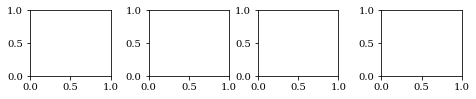

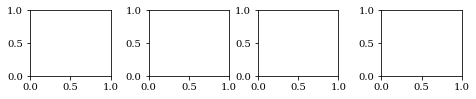

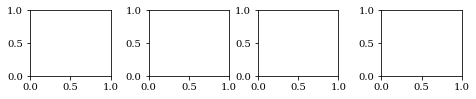

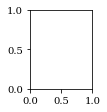

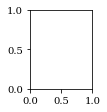

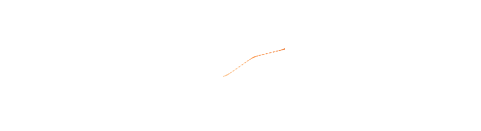

In [73]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('trajec3', 'trajec')]
plot_trajectory('alignpsi', ax, colormap='Oranges', turn_amplitude = '20deg')

layout.append_figure_to_layer(layout.figures['trajec3'], 'trajec20', cleartarget=True)
layout.write_svg(fififig)

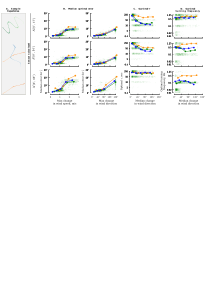

In [74]:
from IPython.display import display,SVG
display(SVG(fififig))

# different trajectories

In [75]:
fififig = '../figures_svg/fig_12_summary_trajec.svg'

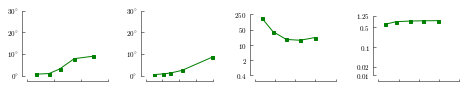

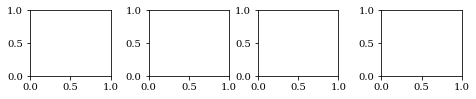

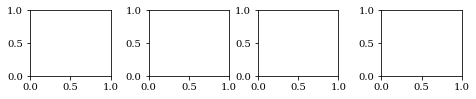

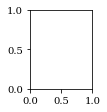

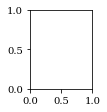

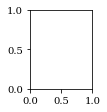

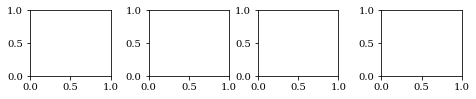

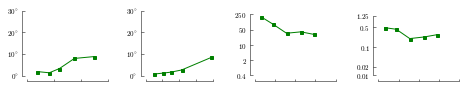

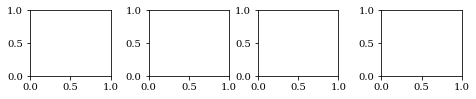

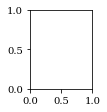

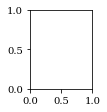

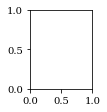

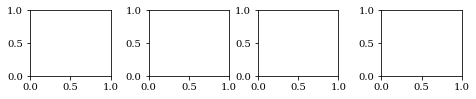

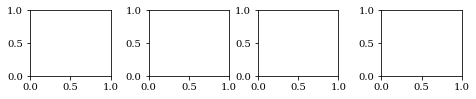

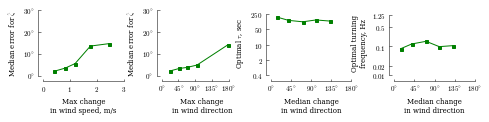

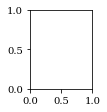

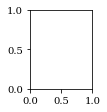

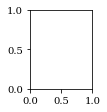

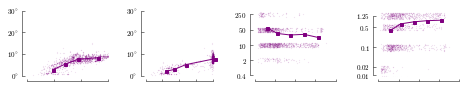

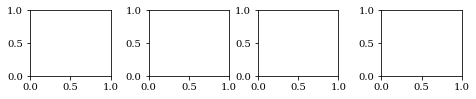

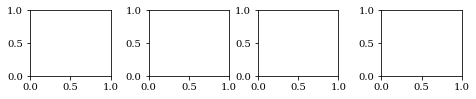

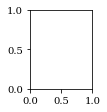

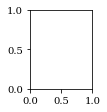

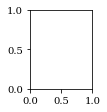

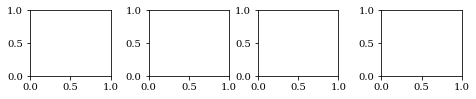

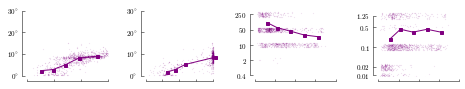

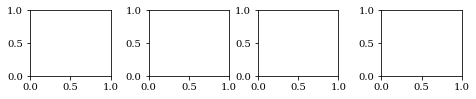

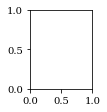

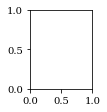

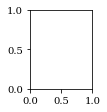

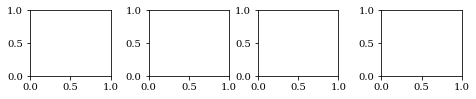

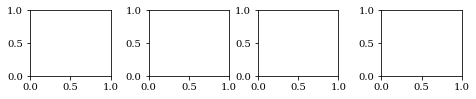

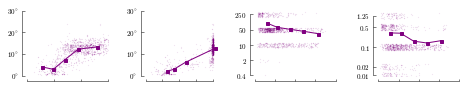

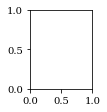

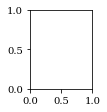

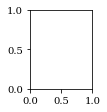

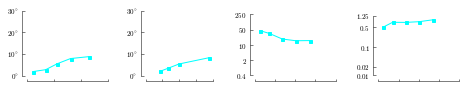

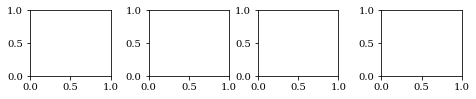

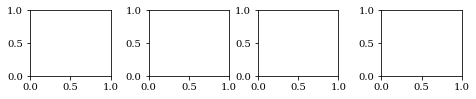

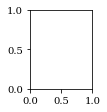

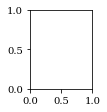

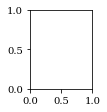

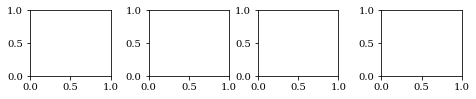

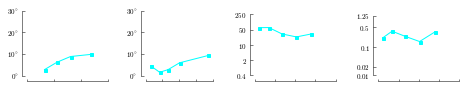

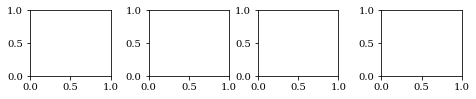

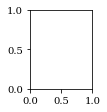

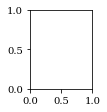

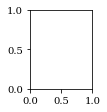

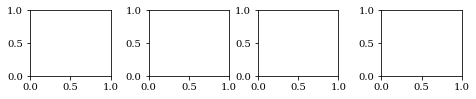

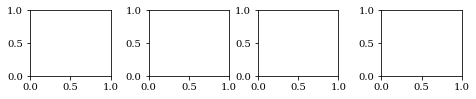

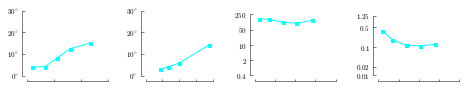

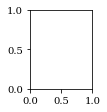

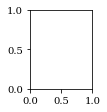

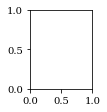

In [76]:
for noise_std in [0.3, 0.6, 1.2]:
    turn_angle = 180
    phi_alignment = 'alignpsi'
    speed = 'absine'
    label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
    df = data_for_summary_plot[label]
    
    if noise_std == 1.2:
        show_labels = True
    else:
        show_labels = False
    plot_noise_level(fififig, int(noise_std*10), df, color='green', show_labels=show_labels, 
                     show_scatters=False)
    
    
    
for noise_std in [0.3, 0.6, 1.2]:
    turn_angle = 180
    phi_alignment = 'aligngamma'
    speed = 'absine'
    label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
    df = data_for_summary_plot[label]
    
    show_labels = False
    plot_noise_level(fififig, int(noise_std*10), df, color='purple', show_scatters=True,
                     figpanel_save=str(noise_std)+'_aligngamma', mean_offset=1)
    
for noise_std in [0.3, 0.6, 1.2]:
    turn_angle = 180
    phi_alignment = 'alignpsi'
    speed = 'constant'
    label = 'summarydata_' + str(turn_angle) + '_' + str(noise_std) + '_' + phi_alignment + '_' + speed + '.hdf'
    df = data_for_summary_plot[label]
    
    show_labels = False
    plot_noise_level(fififig, int(noise_std*10), df, color='cyan', show_scatters=False,
                     figpanel_save=str(noise_std)+'_constant', mean_offset=-1)

300 0.09999990463256836
Number of turns per sec:  0.16722423974502104


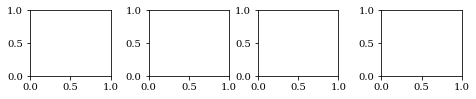

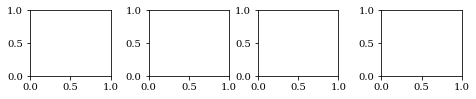

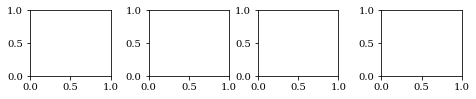

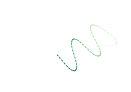

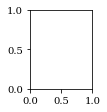

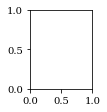

In [77]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('trajec', 'trajec')]
plot_trajectory('alignpsi', ax, colormap='Greens', turn_amplitude = '180deg')

layout.append_figure_to_layer(layout.figures['trajec'], 'trajec', cleartarget=True)
layout.write_svg(fififig)

300 0.09999990463256836
Number of turns per sec:  0.16722423974502104


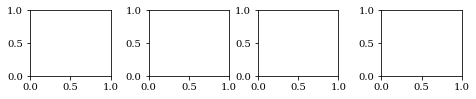

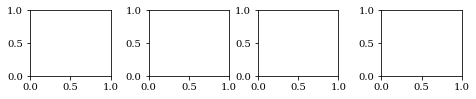

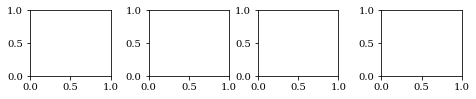

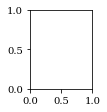

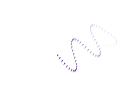

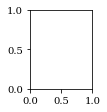

In [78]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('trajec2', 'trajec')]
plot_trajectory('constantgamma', ax, colormap='Purples', turn_amplitude = '180deg')

layout.append_figure_to_layer(layout.figures['trajec2'], 'trajec2', cleartarget=True)
layout.write_svg(fififig)

300 0.09999990463256836
Number of turns per sec:  0.16722423974502104


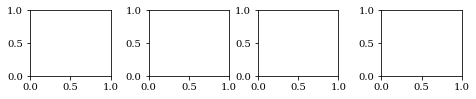

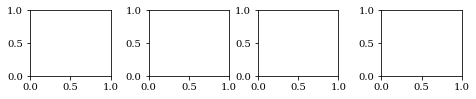

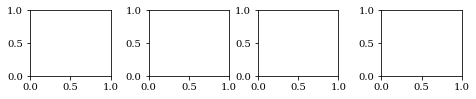

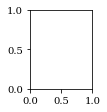

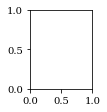

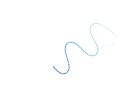

In [79]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('trajec3', 'trajec')]
plot_trajectory('constantvel', ax, colormap='Blues', turn_amplitude = '180deg')

layout.append_figure_to_layer(layout.figures['trajec3'], 'trajec3', cleartarget=True)
layout.write_svg(fififig)

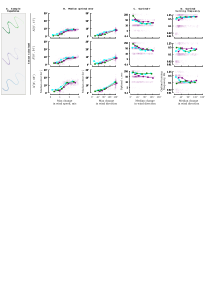

In [87]:
from IPython.display import display,SVG
display(SVG(fififig))